In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Cell 1 — Setup

In [5]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np

# Make sure project root is on sys.path
PROJECT_ROOT = Path().resolve().parents[0]
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.data.load import load_yaml, load_all_sources, add_broad_category
from src.models.classifier import train_text_classifier
from src.models.evaluation import evaluate_classifier


Cell 2 — Load data + mapping

In [6]:
cfg = load_yaml(PROJECT_ROOT / 'configs' / 'model_svm.yaml')

df = load_all_sources(cfg, root=PROJECT_ROOT)
df = add_broad_category(df, cfg, root=PROJECT_ROOT)

print(df.shape)
df[['source', 'categories', 'broad_category']].head()


INFO:src.data.load:Loading source pakistan_today from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/pakistan_today(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading source tribune from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/tribune(full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source dawn from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/dawn (full-data).csv (encoding=latin1)
INFO:src.data.load:Loading source daily_times from /home/spark/NUST/Semester 5/Data Mining/Project/data/raw/daily_times(full-data).csv (encoding=utf-8)
INFO:src.data.load:Loading preprocessed business_reorder from /home/spark/NUST/Semester 5/Data Mining/Project/data/interim/business_reorder_clean.parquet
INFO:src.data.load:Filtered invalid sources: (625905, 7) -> (624642, 7)
INFO:src.data.load:Combined dataset shape: (624642, 7)
INFO:src.data.load:Sampling up to 10000 rows per source (__file__ column).
/home/spark/NUST/Semester 5/Data Mining/Project/s

(40000, 8)


,source,categories,broad_category
0,Daily Times,World,World
1,Daily Times,Pakistan,Pakistan
2,Daily Times,Pakistan,Pakistan
3,Daily Times,Pakistan & Top Stories,Pakistan
4,Daily Times,World,World


Cell 3 — Train and evaluate

In [7]:
model, X_train, X_test, y_train, y_test, _ = train_text_classifier(df, cfg)
y_pred = model.predict(X_test)

metrics = evaluate_classifier(y_test, y_pred)
metrics['accuracy'], metrics['macro_f1'], metrics['labels']


(0.86025,
 0.8247037264255088,
 ['Business',
  'Lifestyle',
  'Opinion',
  'Other',
  'Pakistan',
  'Sports',
  'Technology',
  'World'])

Cell 4 — Confusion matrix plot

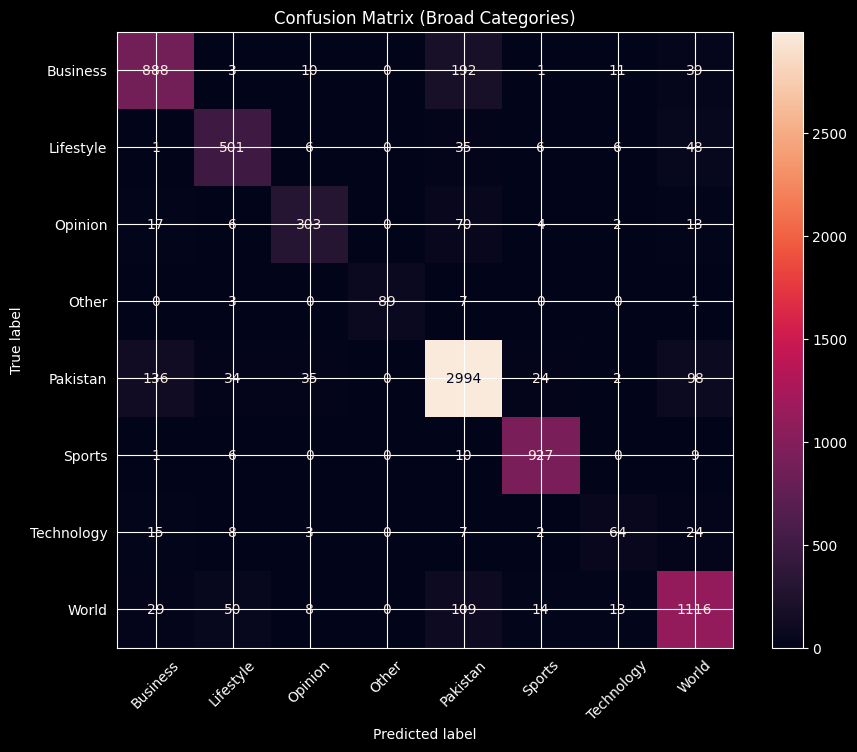

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

labels = metrics['labels']
cm = np.array(metrics['confusion_matrix'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap=None, xticks_rotation=45)
plt.title('Confusion Matrix (Broad Categories)')
plt.show()


Cell 5 — Show top misclassified examples (super important for report)

In [9]:
# Build a readable table of mistakes
mistakes = []
for x, yt, yp in zip(X_test, y_test, y_pred):
    if yt != yp:
        mistakes.append({'true': yt, 'pred': yp, 'text': x[:400]})

mistakes_df = pd.DataFrame(mistakes)
mistakes_df.head(10)


,true,pred,text
0,Pakistan,Business,Govt gets financial relief as China rolls over...
1,Business,Pakistan,Pakistan pledges $3m to fight coronavirus in S...
2,Business,Pakistan,UN forecasts China’s economic growth of 5.3% i...
3,Business,Pakistan,Pak-China trade resumes temporarily through Kh...
4,Technology,Business,"Coinbase gets all-clear from SEC, setting stag..."
5,World,Pakistan,Pandemic takes a toll on exhausted UK funeral ...
6,World,Lifestyle,American singer Mariah Carey sued over hit sin...
7,Pakistan,Business,Punjab flour mills association declares strike...
8,Business,World,UK quarantine move hits fragile airline recove...
9,Opinion,Pakistan,Ban earphones Ears are a big blessing from All...


Cell 6 — Most confused pairs

In [10]:
pair_counts = (
    mistakes_df.groupby(['true', 'pred'])
    .size()
    .sort_values(ascending=False)
    .reset_index(name='count')
)

pair_counts.head(15)


,true,pred,count
0,Business,Pakistan,192
1,Pakistan,Business,136
2,World,Pakistan,109
3,Pakistan,World,98
4,Opinion,Pakistan,70
5,World,Lifestyle,50
6,Lifestyle,World,48
7,Business,World,39
8,Pakistan,Opinion,35
9,Lifestyle,Pakistan,35


Cell 7 — Save to `experiments/results/`

In [11]:
out_dir = PROJECT_ROOT / 'experiments' / 'results'
out_dir.mkdir(parents=True, exist_ok=True)

mistakes_df.to_csv(out_dir / 'svm_misclassified_samples.csv', index=False)
pair_counts.to_csv(out_dir / 'svm_confused_pairs.csv', index=False)

print('Saved:', out_dir)


Saved: /home/spark/NUST/Semester 5/Data Mining/Project/experiments/results
